# Setup

In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import tikzplotlib

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [40]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])



def plot_spk_mem_spk(spk1, mem, spk2, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input spike using spikeplot
  splt.raster(spk1, ax[0], s=400, c="black", marker="|")
  if vline:
    ax[0].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[0].set_ylabel("Input spikes")
  ax[0].set_yticks([])

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk2, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[2].set_ylabel("Output spikes")
  ax[2].set_yticks([])

# LIF

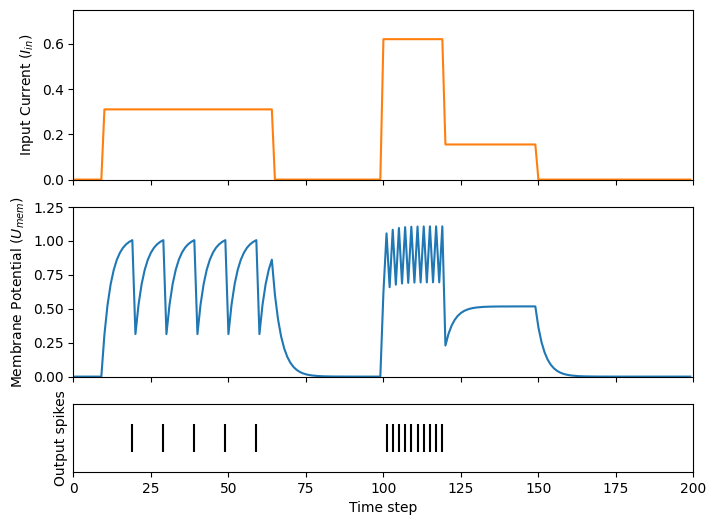

In [7]:
lif1 = snn.Leaky(beta=0.70)

# Small step current input
w=0.31
cur_in = torch.cat((torch.zeros(10), torch.ones(55)*w, torch.zeros(35), torch.ones(20)*2*w, torch.ones(30)*0.5*w, torch.zeros(50)), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(200):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, ylim_max1=0.75)
tikzplotlib.save("LIF.tex")


# LIF (Spiking Input)

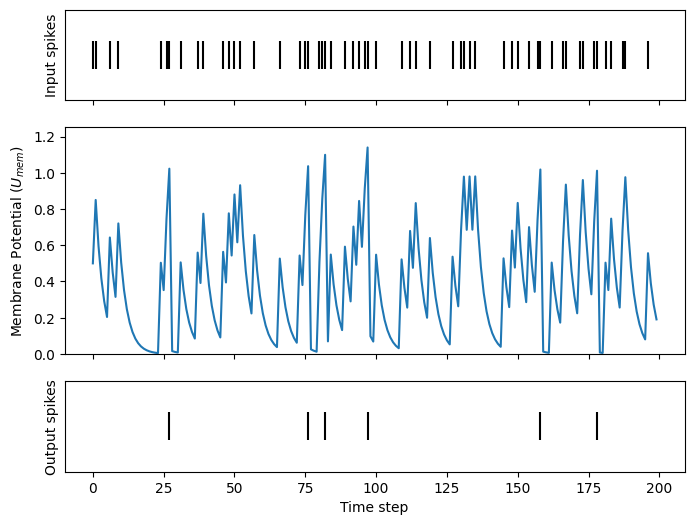

In [43]:
lif1 = snn.Leaky(beta=0.70)

# Small step current input
w=0.5
spk_in = spikegen.rate_conv(torch.ones((200)) * 0.30) * 0.5
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(200):
  spk, mem = lif1(spk_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, ylim_max1=0.75)
tikzplotlib.save("LIFspike.tex")

# Lapicque

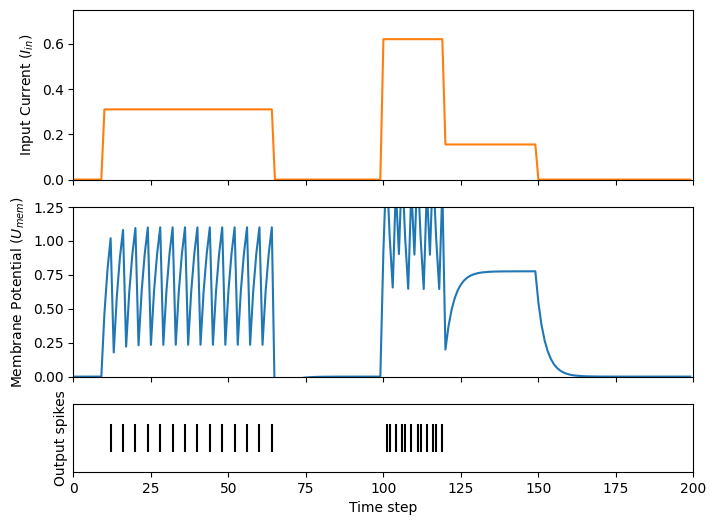

In [13]:
time_step = 1.5e-3
R = 5    # 5 M-ohm
C = 1e-3 # 100 pF
# Therefore Tau/Decay Rate = 5e-3 seconds or 5 time steps

# leaky integrate and fire neuron, tau=5e-3
lpq1 = snn.Lapicque(R=R, C=C, time_step=time_step)

# Small step current input
w=0.31
cur_in = torch.cat((torch.zeros(10), torch.ones(55)*w, torch.zeros(35), torch.ones(20)*2*w, torch.ones(30)*0.5*w, torch.zeros(50)), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(200):
  spk, mem = lpq1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, ylim_max1=0.75)
tikzplotlib.save("Lapicque.tex")